<a href="https://colab.research.google.com/github/andy698087/BERT-DNN_cpx/blob/main/BERT_w_DL_20221104_64BS_structure3%2Banestype_cpx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
! pip install transformers
! pip3 install pickle5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.5 MB 5.0 MB/s 
     |████████████████████████████████| 163 kB 71.5 MB/s 
     |████████████████████████████████| 7.6 MB 46.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 256 kB 4.6 MB/s 


In [3]:
path = '/content/drive/MyDrive/BERT_yk_PeiFu_copy20210628/'

In [4]:
import torch
torch.cuda.get_device_name()

'Tesla T4'

In [5]:
import pickle5 as pickle
with open('/content/drive/MyDrive/BERT_yk_PeiFu_copy20210628/comb_inner_30_20210807.pkl', "rb") as fh:
  data = pickle.load(fh)
data.head()

,病歷編號,性別,術前診斷,預計手術日期,Pre_OP_Location,生日,身高,體重,年齡,訪視地點,...,E,I,O,轉換住院日期,轉換出院日期,mi,ca,pnm,stk,sps
0,1000001424,0.0,left ureter stone,2016-03-02 00:00:00,床號12G161,1951-3-18,-0.645034,0.651017,0.686103,諮詢室,...,0.0,0.0,0.0,2016-03-01,2016-03-03,False,False,False,False,False
1,1000000603,1.0,RUS with HN,2019-09-24 00:00:00,床號09G222,1951-11-1,-0.293083,0.084077,0.866067,諮詢室,...,0.0,0.0,0.0,2019-09-23,2019-09-24,False,False,False,False,False
6,1000000603,1.0,Acute Cholecystitis,2017-01-02 00:00:00,急診,1951-11-1,0.058868,0.154944,0.746091,等候區,...,1.0,0.0,0.0,2017-01-02,2017-01-03,False,False,False,False,False
8,1000000603,1.0,BPH,2019-07-05 00:00:00,床號12G121,1951-11-1,-0.293083,0.154944,0.866067,諮詢室,...,0.0,0.0,0.0,2019-07-04,2019-07-08,False,False,False,False,False
10,1000000603,1.0,RUS post,2019-10-08 00:00:00,門診,1951-11-1,-0.293083,-0.128526,0.866067,諮詢室,...,0.0,0.0,1.0,2019-09-23,2019-09-24,False,False,False,False,False


In [6]:
data = data[data.進入手術室日期時間.notnull() & data.離開手術室日期時間.notnull() & data.預計手術名稱.notnull() & data.術前診斷.notnull() & (data['麻醉危險分級(ASA Class)'] != 6)]

In [7]:
from sklearn.preprocessing import StandardScaler
import numpy as np
scal_fea = ['身高', '體重', 'BMI', '年齡', 'LABDATA_HB', 'LABDATA_PLATELET', 'LABDATA_INR',
       'LABDATA_PT', 'LABDATA_APTT', 'LABDATA_CR', 'LABDATA_GOT',
       'LABDATA_GPT', 'LABDATA_SUGAR', 'LABDATA_NA', 'LABDATA_K', 'BT', 'SPO2', 'HR', 'RR', 'SBP', 'DBP']
scaler = StandardScaler()
scaler.fit(data[scal_fea])
print(scaler.mean_, scaler.var_)
data.loc[:,scal_fea] = scaler.transform(data[scal_fea])
# data.loc[:,scal_fea] = data.loc[:,scal_fea].astype(np.float32)

[ 0.01671829  0.03312068  0.03018294  0.02703002  0.0194257  -0.00859235
  0.00064894 -0.00060636  0.00721948  0.01469098 -0.00173124  0.00025457
  0.01376882 -0.00320524 -0.00077995  0.01790226 -0.01770573 -0.00132862
  0.00696055  0.01714639  0.01744   ] [1.02221261 1.00732491 1.00442724 1.00790918 1.05334929 1.04404279
 1.06299787 1.07647573 1.0372836  1.05675078 1.08024626 0.97204843
 1.06857634 1.05003907 1.08255691 1.0351081  1.01165754 1.0151423
 1.00491714 1.06463456 1.00849845]


In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stops = set(stopwords.words("english"))

import re
def clean_str(string):
    """
    Tokenization/string cleaning for all datasets except for SST.
    Original taken from https://github.com/yoonkim/CNN_sentence/blob/master/process_data.py
    """
    # string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"[^A-Za-z0-9]", " ", string)
    string = re.sub(r"[0-9]{4,}", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.split()
    string = [w for w in string if not w in stops]
    string = " ".join(string)
    return string.strip().lower()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
data['術前診斷']=data['術前診斷'].apply(clean_str)
data['預計手術名稱']=data['預計手術名稱'].apply(clean_str)

In [10]:
data.columns

Index(['病歷編號', '性別', '術前診斷', '預計手術日期', 'Pre_OP_Location', '生日', '身高', '體重',
       '年齡', '訪視地點',
       ...
       'E', 'I', 'O', '轉換住院日期', '轉換出院日期', 'mi', 'ca', 'pnm', 'stk', 'sps'],
      dtype='object', length=122)

In [11]:
print(data['麻醉危險分級(ASA Class)'].value_counts(dropna=False),'\n')
data['麻醉危險分級(ASA Class)']=data['麻醉危險分級(ASA Class)'].fillna(2)
print(data['麻醉危險分級(ASA Class)'].value_counts(dropna=False))

2.0    69573
3.0    26708
1.0     3171
4.0     1664
5.0      142
Name: 麻醉危險分級(ASA Class), dtype: int64 

2.0    69573
3.0    26708
1.0     3171
4.0     1664
5.0      142
Name: 麻醉危險分級(ASA Class), dtype: int64


In [12]:
import pandas as pd
def anes_type(x):
    if x == 'EA' or x == 'SA':
        return 'RA'
    elif pd.isna(x):
        return 'Rnone'
    else:
        return x
data.麻醉計畫 = data.麻醉計畫.apply(anes_type)   
data.麻醉計畫.value_counts()     

ETGA            60839
IVGA            14636
RA              13993
Mask GA(LMA)    11659
Rnone             131
Name: 麻醉計畫, dtype: int64

In [13]:
from sklearn.preprocessing import OneHotEncoder

enc=OneHotEncoder()
enc.fit(data[['麻醉危險分級(ASA Class)', '手術部門', '開刀類別', 'Route', '麻醉計畫']])
print(enc.categories_)

col_enc=[]
for i in enc.categories_:
  for j in i:
    if isinstance(j,str) and j != 'Rnone':
      col_enc.append(j)
    elif j == 'Rnone':
      continue
    else:
      col_enc.append('asa_' + str(int(j)))
print(col_enc)

[array([1., 2., 3., 4., 5.]), array(['一般外科                      ', '人工耳蝸中心                  ',
       '創傷科                        ', '口腔顎面外科                  ',
       '大腸直腸外科                  ', '婦產部                        ',
       '小兒外科                      ', '小兒部                        ',
       '形體美容醫學中心              ', '影像醫學科                    ',
       '心臟血管內科                  ', '心臟血管外科                  ',
       '整形外科                      ', '泌尿科                        ',
       '牙科部                        ', '眼科部                        ',
       '神經外科                      ', '耳鼻喉科暨頭頸外科            ',
       '肝膽胃腸科                    ', '胸腔外科                      ',
       '骨科部                        ', '麻醉部                        '],
      dtype=object), array(['急急刀', '急症刀', '正常刀', '緊急刀'], dtype=object), array(['A', 'E', 'I', 'O'], dtype=object), array(['ETGA', 'IVGA', 'Mask GA(LMA)', 'RA', 'Rnone'], dtype=object)]
['asa_1', 'asa_2', 'asa_3', 'asa_4', 'asa_5', '一般外科         

In [14]:
import pandas as pd
for i in range(len(col_enc)):
  data[col_enc[i]] = enc.transform(data[['麻醉危險分級(ASA Class)', '手術部門', '開刀類別', 'Route', '麻醉計畫']]).toarray()[:,i]
data.head()

,病歷編號,性別,術前診斷,預計手術日期,Pre_OP_Location,生日,身高,體重,年齡,訪視地點,...,轉換出院日期,mi,ca,pnm,stk,sps,ETGA,IVGA,Mask GA(LMA),RA
0,1000001424,0.0,left ureter stone,2016-03-02 00:00:00,床號12G161,1951-3-18,-0.654523,0.615646,0.656482,諮詢室,...,2016-03-03,False,False,False,False,False,0.0,1.0,0.0,0.0
1,1000000603,1.0,rus hn,2019-09-24 00:00:00,床號09G222,1951-11-1,-0.306417,0.050770,0.835738,諮詢室,...,2019-09-24,False,False,False,False,False,0.0,0.0,1.0,0.0
6,1000000603,1.0,acute cholecystitis,2017-01-02 00:00:00,急診,1951-11-1,0.041690,0.121380,0.716234,等候區,...,2017-01-03,False,False,False,False,False,1.0,0.0,0.0,0.0
8,1000000603,1.0,bph,2019-07-05 00:00:00,床號12G121,1951-11-1,-0.306417,0.121380,0.835738,諮詢室,...,2019-07-08,False,False,False,False,False,1.0,0.0,0.0,0.0
10,1000000603,1.0,rus post,2019-10-08 00:00:00,門診,1951-11-1,-0.306417,-0.161058,0.835738,諮詢室,...,2019-09-24,False,False,False,False,False,0.0,1.0,0.0,0.0


In [15]:
data['text'] = data['術前診斷'] + ' ' + data['預計手術名稱']
print(data['text'])

0                              left ureter stone ursl laser
1                                         rus hn ursl laser
6                       acute cholecystitis lc ioc 10 5 3 3
8                                     bph laser prostectomy
10                                     rus post removal dbj
                                ...                        
505004          acute appendicitis laparosopic appendectomy
505005            right foot 2nd pip joint dislocation orif
505006    left knee anterior cruciate ligament rupture a...
505007      right hydronephrosis urs exam dbj insertion pcn
505013                            esophageal achalasia poem
Name: text, Length: 101258, dtype: object


In [16]:
data['cpx'] = data[['mi', 'ca', 'pnm', 'stk', 'sps']].apply(any,axis=1)

In [18]:
data.to_pickle(path+'preprocessed_20210716_20221106cpx.pkl')

In [17]:
data.columns.tolist()

['病歷編號',
 '性別',
 '術前診斷',
 '預計手術日期',
 'Pre_OP_Location',
 '生日',
 '身高',
 '體重',
 '年齡',
 '訪視地點',
 '資料來源',
 '手術部門',
 '手術醫師',
 '預計手術名稱',
 '病史_DM',
 '病史_HYPERLIPIDEMIA',
 '病史_HYPERTENSION',
 '病史_CVA',
 '病史_CARDIAC_DISEASE',
 '病史_COPD',
 '病史_ASTHMA',
 '病史_HEPATIC_DISEASE',
 '病史_RENAL_DISEASE',
 '病史_BLEEDING_DISORDER',
 '病史_MAJOR_OPERATIONS',
 '病史_SMOKING',
 '病史_ALLERGY',
 'LABDATA_血型',
 'LABDATA_HB',
 'LABDATA_HCT',
 'LABDATA_PLATELET',
 'LABDATA_INR',
 'LABDATA_PT',
 'LABDATA_APTT',
 'LABDATA_BUN',
 'LABDATA_CR',
 'LABDATA_GOT',
 'LABDATA_GPT',
 'LABDATA_SUGAR',
 'LABDATA_NA',
 'LABDATA_K',
 'LABDATA_其他',
 'LABDATA_CXR',
 'LABDATA_EKG',
 'LABDATA_其他特殊檢驗',
 'PONV Risk Factor',
 'Special Conditions',
 '呼吸道評估',
 '麻醉危險分級(ASA Class)',
 'ASA_CLASS_E',
 'ASA_CLASS_重大手術',
 'ASA_CLASS_特殊案例',
 '麻醉計畫',
 '特殊處置',
 '特殊處置_其他',
 '曾經手術麻醉中發生的特殊事件',
 '高危附註',
 '訪視日期',
 '術前諮詢時間',
 '訪視麻醉醫師',
 '麻醉誘導前評估',
 '最後進食時間',
 'BT',
 'SPO2',
 'HR',
 'RR',
 'BP',
 '意識',
 '手術日期',
 '排程手術名稱',
 '進入手術室日期時間',
 '離開手術室日期時間',
 '開刀類別',


In [19]:
fea =['性別', '身高', '體重', 'BMI', '年齡', '病史_DM', '病史_HYPERLIPIDEMIA',
       '病史_HYPERTENSION', '病史_CVA', '病史_CARDIAC_DISEASE', '病史_COPD',
       '病史_ASTHMA', '病史_HEPATIC_DISEASE', '病史_RENAL_DISEASE',
       '病史_BLEEDING_DISORDER', '病史_MAJOR_OPERATIONS', '病史_SMOKING',
       '病史_ALLERGY', 'LABDATA_HB', 'LABDATA_PLATELET', 'LABDATA_INR',
       'LABDATA_PT', 'LABDATA_APTT', 'LABDATA_CR', 'LABDATA_GOT',
       'LABDATA_GPT', 'LABDATA_SUGAR', 'LABDATA_NA', 'LABDATA_K',
       'ASA_CLASS_E', 'BT', 'SPO2', 'HR', 'RR', 'SBP', 'DBP', '意識',
       'asa_1',
        'asa_2',
        'asa_3',
        'asa_4',
        'asa_5',
        '一般外科                      ',
        '人工耳蝸中心                  ',
        '創傷科                        ',
        '口腔顎面外科                  ',
        '大腸直腸外科                  ',
        '婦產部                        ',
        '小兒外科                      ',
        '小兒部                        ',
        '形體美容醫學中心              ',
        '影像醫學科                    ',
        '心臟血管內科                  ',
        '心臟血管外科                  ',
        '整形外科                      ',
        '泌尿科                        ',
        '牙科部                        ',
        '眼科部                        ',
        '神經外科                      ',
        '耳鼻喉科暨頭頸外科            ',
        '肝膽胃腸科                    ',
        '胸腔外科                      ',
        '骨科部                        ',
        '麻醉部                        ',
        '急急刀',
        '急症刀',
        '正常刀',
        '緊急刀',
        'A',
        'E',
        'I',
        'O',
        'ETGA',
        'IVGA',
        'Mask GA(LMA)',
        'RA',
        'text']
nontext_fea=fea[:-1]
target='cpx'
# nontext_fea

In [20]:
data[target] = data[target].astype(np.int8)

In [21]:
data[nontext_fea].shape

(101258, 76)

In [22]:
import pandas as pd
data_train = data[data["離開手術室日期時間"]<pd.to_datetime('2020/1/1')]
hisn_in_train = data_train['病歷編號'].unique()
data_test = data[(data["離開手術室日期時間"]>=pd.to_datetime('2020/1/1')) & (data["離開手術室日期時間"]<=pd.to_datetime('2020/11/30')) & (~data['病歷編號'].isin(hisn_in_train))]

In [23]:
X_train, y_train = data_train.loc[:,fea], data_train.loc[:,target]
X_test, y_test = data_test.loc[:,fea], data_test.loc[:,target]

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast, AutoTokenizer
from collections import Counter
import os

result_directory = path + 'eval_results/221104_sturct3anestype_cpx/'
model_label = 'BERT_with_DL_221104_sturct3anestype_cpx'
if not os.path.exists(result_directory):
    
    os.makedirs(result_directory)
    print("directory created")


train_fea, val_fea, train_labels, val_labels = train_test_split(
    X_train[fea], y_train, stratify=y_train, random_state=2018, test_size=0.2)

train_text, train_nontext = train_fea['text'], train_fea[nontext_fea]
val_text, val_nontext = val_fea['text'], val_fea[nontext_fea]


test_text, test_nontext, test_labels = X_test['text'], X_test[nontext_fea], y_test


bert = AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")


seq_len = [len(i.split()) for i in data['text']]
max_len = np.array(seq_len).max()
print('max length =',max_len)


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

max length = 40


In [25]:
device = torch.device("cuda")
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    padding= 'max_length',    
    max_length = 50,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer(
    val_text.tolist(),
    padding= 'max_length',    
    max_length = 50,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer(
    test_text.tolist(),
    padding= 'max_length',    
    max_length = 50,
    truncation=True
)

train_seq = torch.tensor(tokens_train['input_ids'])
train_nontext = torch.tensor(np.array(train_nontext,dtype=np.float32))
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())



val_seq = torch.tensor(tokens_val['input_ids'])
val_nontext = torch.tensor(np.array(val_nontext,dtype=np.float32))
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())



test_seq = torch.tensor(tokens_test['input_ids'])
test_nontext = torch.tensor(np.array(test_nontext,dtype=np.float32))
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(torch.cat((train_seq,train_nontext),1).float(), train_mask,  train_y.long())

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(torch.cat((val_seq,val_nontext),1).float(), val_mask, val_y.long())

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)



class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
      # dropout layer
        self.dropout = nn.Dropout(0.2)
      
      # relu activation function
        self.relu =  nn.ReLU()

      # Dropout
        self.dropout = nn.Dropout(p=0.2)
        
      # Batch normalise
        # self.batchnorm1 = nn.BatchNorm1d(64)

      # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (BERT Output layer)
        self.fc2 = nn.Linear(512,64)

      # dense layer 0 
        self.fc0 = nn.Linear(76,32)
      # dense layer 3 
        self.fc3 = nn.Linear(64+32,64)

      # dense layer 4
        self.fc4 = nn.Linear(64,32)

      # output layer
        self.layer_out = nn.Linear(32,2)

      #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)
      
    #define the forward pass
    def forward(self, sent_id):

      #pass the inputs to the model  
        cls_hs = self.bert(sent_id[:,:-76].long(), return_dict=False)[1]

        x = self.fc1(cls_hs)

      # output layer of BERT
        x = self.fc2(x)
        x = self.relu(x)
        # x = self.dropout(x)
        
      # cat of BERT and DNN
        x2 = sent_id[:,-76:].float()
        x2 = self.fc0(x2)
        x = self.fc3(torch.cat((x,x2),1))
        x = self.relu(x)
        x = self.dropout(x)      
        
        x = self.fc4(x)
        # x = self.batchnorm1(x)
        x = self.relu(x)
        # x = self.dropout(x)
      
      # output layer
        x = self.layer_out(x)

      # apply softmax activation
        x = self.softmax(x)
      #to_device(device) drop out of GPU
      #Bert2
        return x
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)


In [31]:

from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 2e-5)          # learning rate


from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights_ = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y= train_labels)
#class_weights = [0.5, 38]

print("Class Weights:",class_weights_)

# converting list of class weights to a tensor
weights= torch.tensor(class_weights_,dtype=torch.float)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights.to(device)) 

# number of training epochs
epochs = 100

# from torch.utils.tensorboard import SummaryWriter
# writer = SummaryWriter(result_directory+'/runs')

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc


# function to train the model
def train(step_train):
    model.train()
    total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
    total_preds=[]
  
  # iterate over batches
    for step, batch in enumerate(train_dataloader):
        step_train = step_train + 1
    # push the batch to gpu
        batch = [r.to(device).long() for r in batch]
        sent_id, mask, labels = batch
                
    # clear previously calculated gradients 
        model.zero_grad()        

    # get model predictions for the current batch
        preds = model(sent_id)

    # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)
        acc = multi_acc(preds, labels)

        # writer.add_scalar("Loss/train", loss, step_train)
    # add on to the total loss
        total_loss += loss.item()
        total_accuracy += acc.item()
    # backward pass to calculate the gradients
        loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
        optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()

    # append the model predictions
        total_preds.append(preds)

  # compute the training loss of the epoch
        avg_loss = total_loss / len(train_dataloader)
        avg_acc = total_accuracy / len(train_dataloader)
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
    return avg_loss, avg_acc, total_preds, step_train

# function for evaluating the model
def evaluate(step_test):
    print("\nEvaluating...")
  
  # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
  
    # empty list to save the model predictions
    total_preds = []

    # iterate over batches
    for step, batch in enumerate(val_dataloader):
        step_test = step_test + 1
        # push the batch to gpu
        batch = [t.to(device).long() for t in batch]
        sent_id, mask, labels = batch
        
        # deactivate autograd
        with torch.no_grad():
      
            # model predictions
            preds = model(sent_id)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)
            

            acc = multi_acc(preds, labels)
            total_loss += loss.item()
            total_accuracy += acc.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)

  # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    avg_acc = total_accuracy / len(val_dataloader)
  # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, avg_acc, total_preds, step_test

# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch

if not os.path.exists(result_directory+'loss'):    
    os.makedirs(result_directory+'loss')
    print("loss directory created")


with open(result_directory+'loss/train_loss.log','w') as f:
  f.write('')
with open(result_directory+'loss/valid_loss.log','w') as f:
  f.write('')



accuracy_stats = {
    'train': [],
    "val": []
}
loss_stats = {
    'train': [],
    "val": []
}
step_train = 0
step_test = 0
#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch, epochs))
    
    #train model
    train_loss, train_acc, _, step_train = train(step_train)
    
    #evaluate model
    valid_loss, valid_acc, _, step_test = evaluate(step_test)
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), result_directory+str(epoch)+'saved_weights_{}.pt'.format(model_label))
        print("Model Updated!")
        #model.save_pretrained("directory")
    elif epoch % 10 == 9:
        torch.save(model.state_dict(), result_directory+str(epoch)+'saved_weights_{}.pt'.format(model_label))
        # print("Model Updated!")
        #model.save_pretrained("directory")
    
    # append training and validation loss
    loss_stats['train'].append(train_loss)
    loss_stats['val'].append(valid_loss)
    accuracy_stats['train'].append(train_acc)
    accuracy_stats['val'].append(valid_acc)
    

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining acc: {train_acc:.3f}')
    print(f'Validation acc: {valid_acc:.3f}')
    with open(result_directory+'loss/train_loss.log','a') as f:
      f.write(str(train_loss))
      f.write('\n')
    with open(result_directory+'loss/valid_loss.log','a') as f:
      f.write(str(valid_loss))
      f.write('\n')
    torch.save(model.state_dict(), result_directory+'last_saved_weights_{}.pt'.format(model_label))
# writer.flush()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Class Weights: [ 0.50860105 29.56621005]
loss directory created

 Epoch 0 / 100

Evaluating...
Model Updated!

Training Loss: 0.665
Validation Loss: 0.663

Training acc: 98.157
Validation acc: 98.150

 Epoch 1 / 100

Evaluating...

Training Loss: 0.666
Validation Loss: 0.664

Training acc: 98.152
Validation acc: 98.150

 Epoch 2 / 100

Evaluating...

Training Loss: 0.662
Validation Loss: 0.663

Training acc: 98.152
Validation acc: 98.150

 Epoch 3 / 100

Evaluating...

Training Loss: 0.665
Validation Loss: 0.663

Training acc: 98.154
Validation acc: 98.150

 Epoch 4 / 100

Evaluating...

Training Loss: 0.661
Validation Loss: 0.664

Training acc: 98.156
Validation acc: 98.150

 Epoch 5 / 100

Evaluating...
Model Updated!

Training Loss: 0.664
Validation Loss: 0.663

Training acc: 98.165
Validation acc: 98.150

 Epoch 6 / 100

Evaluating...

Training Loss: 0.667
Validation Loss: 0.664

Training acc: 98.154
Validation acc: 98.150

 Epoch 7 / 100

Evaluating...

Training Loss: 0.665
Valida

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

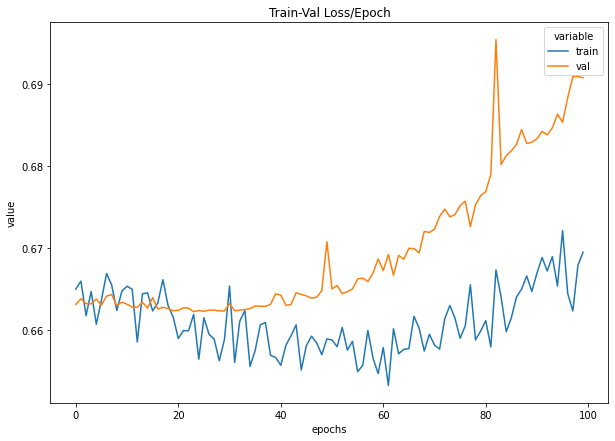

In [32]:
# loss_stats = {
#     'train': [],
#     "val": []
# }
# with open(result_directory+'loss/train_loss.log','r') as f:
#     for i in f.read().split():
#         loss_stats['train'].append(float(i))
# with open(result_directory+'loss/valid_loss.log','r') as f:
#     for i in f.read().split():
#         loss_stats['val'].append(float(i))

train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
import seaborn as sns
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,7))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

In [26]:
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.metrics import roc_auc_score, average_precision_score
# from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# from sklearn.decomposition import PCA
# from sklearn.utils.multiclass import unique_labels
# from sklearn.preprocessing import normalize
from sklearn.utils import resample

import matplotlib.pyplot as plt

plt.rcParams['savefig.dpi'] = 150 #图片像素
plt.rcParams['figure.dpi'] = 150 #分辨率
def plot_roc_curve(fpr, tpr, auc, model):
    plt.plot(fpr, tpr, color='orange', label='ROC_'+model)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve, AUC: {:3f}'.format(auc))
    plt.legend()
    plt.axis([0, 1, 0, 1])
    plt.show()
   


In [27]:
model_label

'BERT_with_DL_221104_sturct3anestype_cpx'

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     13490
           1       0.03      0.02      0.02       228

    accuracy                           0.97     13718
   macro avg       0.51      0.50      0.50     13718
weighted avg       0.97      0.97      0.97     13718



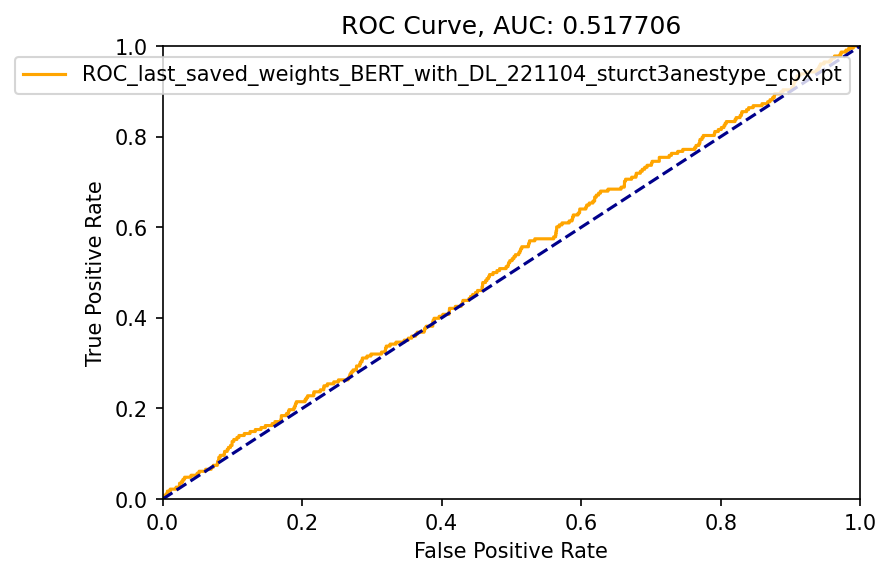

,model,accuracy,confusion matrix,AUROC,AUPRC,Sensitivity,Specificity,Precision,F1_score
0,last_saved_weights_BERT_with_DL_221104_sturct3...,0.97055,"[[13309, 181], [223, 5]]",0.517706,0.018694,0.02193,0.986583,0.026882,0.024155


In [28]:
# 08125-64 model epoch last
device = torch.device("cuda")

model = BERT_Arch(bert) 
choose_epoch = 'last_'
m = torch.load(result_directory+str(choose_epoch)+'saved_weights_{}.pt'.format(model_label)) 
model.load_state_dict(m)
model = model.to(device)

tokens_test = tokenizer(
    test_text.tolist(),
    padding= 'max_length',    
    max_length = 50,
    truncation=True
)
test_seq = torch.tensor(tokens_test['input_ids'])
test_nontext = torch.tensor(np.array(test_nontext,dtype=np.float32))
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


# wrap tensors
test_data = TensorDataset(torch.cat((test_seq,test_nontext),1), test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

batch_size = 64
# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

total_preds=[]
total_probs=[]
for step, batch in enumerate(test_dataloader):
    
        # Progress update every 50 batches.
        if step % 500 == 0 and not step == 0:
      
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

        # push the batch to gpu
        batch = [t.to(device).long() for t in batch]
        sent_id, mask, labels = batch
        
        # deactivate autograd
        with torch.no_grad():
      
            # model predictions
            preds = model(sent_id)

            # compute the validation loss between actual and predicted values
            #loss = cross_entropy(preds,labels)
            #total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            probs = np.exp(preds[:,1])
            preds = np.argmax(preds, axis = 1)
            total_preds.extend(preds)
            total_probs.extend(probs)
#0817-64 model epoch last
#change probability to threshold
model_name = str(choose_epoch)+'saved_weights_{}.pt'.format(model_label)

threshold_change = []
for i in range(len(total_probs)):
    if total_probs[i] > 0.5 :
        threshold_change.append(1)
    else:
        threshold_change.append(0)
# print(len(test_data), len(test_labels), len(total_probs))

from sklearn.metrics import classification_report
print(classification_report(test_y, threshold_change, target_names=['0', '1']))

classifier_model = []
classifier_accuracy = []
CM = []
AUROC = []
AUPRC = []
fpr_tpr = []
classifier_model.append(model_name)

classifier_accuracy.append(accuracy_score(test_y, threshold_change))

CM.append(confusion_matrix(test_y, threshold_change))
AUROC.append(roc_auc_score(y_test, total_probs))
AUPRC.append(average_precision_score(y_test, total_probs))
fpr, tpr, thresholds = roc_curve(test_y, total_probs)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, roc_auc_score(y_test, total_probs), model_name)

result = {}

result = {
    'model':classifier_model,
    'accuracy':classifier_accuracy,
    'confusion matrix':CM,
    'AUROC': AUROC,
    'AUPRC':AUPRC
}
result = pd.DataFrame(result)
result['Sensitivity'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[1,0]))#recall
result['Specificity'] = result['confusion matrix'].apply(lambda x: x[0,0]/(x[0,0]+x[0,1]))
result['Precision'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[0,1]))#PPV
result['F1_score'] = 2 / ((1/result['Sensitivity'])+(1/result['Precision']))
result

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99     13490
           1       0.00      0.00      0.00       228

    accuracy                           0.98     13718
   macro avg       0.49      0.50      0.50     13718
weighted avg       0.97      0.98      0.98     13718



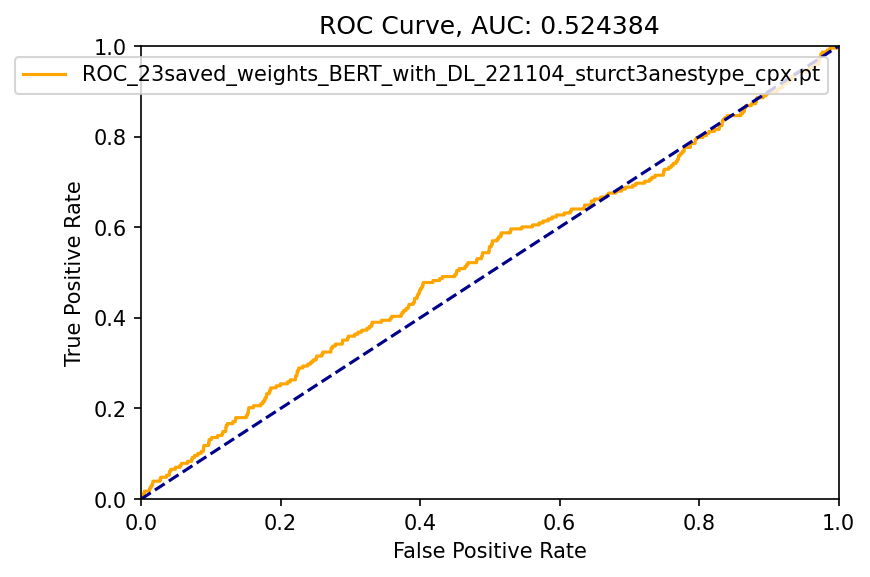

,model,accuracy,confusion matrix,AUROC,AUPRC,Sensitivity,Specificity,Precision,F1_score
0,23saved_weights_BERT_with_DL_221104_sturct3ane...,0.98338,"[[13490, 0], [228, 0]]",0.524384,0.023827,0.0,1.0,NaN,NaN


In [29]:
# 08125-64 model epoch 23
device = torch.device("cuda")

model = BERT_Arch(bert) 
choose_epoch = '23'
m = torch.load(result_directory+str(choose_epoch)+'saved_weights_{}.pt'.format(model_label)) 
model.load_state_dict(m)
model = model.to(device)

total_preds=[]
total_probs=[]
for step, batch in enumerate(test_dataloader):
    
        # Progress update every 50 batches.
        if step % 500 == 0 and not step == 0:
      
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

        # push the batch to gpu
        batch = [t.to(device).long() for t in batch]
        sent_id, mask, labels = batch
        
        # deactivate autograd
        with torch.no_grad():
      
            # model predictions
            preds = model(sent_id)

            # compute the validation loss between actual and predicted values
            #loss = cross_entropy(preds,labels)
            #total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            probs = np.exp(preds[:,1])
            preds = np.argmax(preds, axis = 1)
            total_preds.extend(preds)
            total_probs.extend(probs)
#0817-64 model epoch last
#change probability to threshold
model_name = str(choose_epoch)+'saved_weights_{}.pt'.format(model_label)

threshold_change = []
for i in range(len(total_probs)):
    if total_probs[i] > 0.5 :
        threshold_change.append(1)
    else:
        threshold_change.append(0)
# print(len(test_data), len(test_labels), len(total_probs))

from sklearn.metrics import classification_report
print(classification_report(test_y, threshold_change, target_names=['0', '1']))

classifier_model = []
classifier_accuracy = []
CM = []
AUROC = []
AUPRC = []
fpr_tpr = []
classifier_model.append(model_name)

classifier_accuracy.append(accuracy_score(test_y, threshold_change))

CM.append(confusion_matrix(test_y, threshold_change))
AUROC.append(roc_auc_score(y_test, total_probs))
AUPRC.append(average_precision_score(y_test, total_probs))
fpr, tpr, thresholds = roc_curve(test_y, total_probs)
fpr_tpr += [[fpr, tpr]]
plot_roc_curve(fpr, tpr, roc_auc_score(y_test, total_probs), model_name)

result = {}

result = {
    'model':classifier_model,
    'accuracy':classifier_accuracy,
    'confusion matrix':CM,
    'AUROC': AUROC,
    'AUPRC':AUPRC
}
result = pd.DataFrame(result)
result['Sensitivity'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[1,0]))#recall
result['Specificity'] = result['confusion matrix'].apply(lambda x: x[0,0]/(x[0,0]+x[0,1]))
result['Precision'] = result['confusion matrix'].apply(lambda x: x[1,1]/(x[1,1]+x[0,1]))#PPV
result['F1_score'] = 2 / ((1/result['Sensitivity'])+(1/result['Precision']))
result

In [30]:
cal_sens = lambda x: x[1,1]/(x[1,1]+x[1,0])
cal_spec = lambda x: x[0,0]/(x[0,0]+x[0,1])
cal_prec = lambda x: x[1,1]/(x[1,1]+x[0,1])

def mean_95(x):
    return '%.3f (%.3f - %.3f)' %(np.median(x),np.quantile(x,q=.025),np.quantile(x,q=.975))

data_mean95 = {'Model':[],'AUROC':[],'AUPRC':[],'Accuracy':[],'Sensitivity':[],'Specificity':[],'Precision':[],'F1 score':[]}

In [31]:
#95CI

accuracys = []
AUROCs = []
AUPRCs = []
Senss = []
Specs = []
Precs = []
F1s = []

for i in range(1000):
    if i % 100 == 0: print(i)
    total_preds_, total_probs_, y_test_ = resample(total_preds, total_probs, y_test, random_state=i)
        
    accuracys.append(accuracy_score(y_test_,total_preds_))
    CM = confusion_matrix(y_test_, total_preds_)
    AUROCs.append(roc_auc_score(y_test_, total_probs_))
    AUPRCs.append(average_precision_score(y_test_, total_probs_))
    Sens = cal_sens(CM) #recall
    Spec = cal_spec(CM)
    Prec = cal_prec(CM) #PPV
    F1 = 2 / ((1/Sens)+(1/Prec))
    Senss.append(Sens)
    Specs.append(Spec)
    Precs.append(Prec)
    F1s.append(F1)

data_mean95['Model'].append(model_name)
j=[AUROCs,AUPRCs,accuracys,Senss,Specs,Precs,F1s]

for i,li in enumerate(['AUROC','AUPRC','Accuracy','Sensitivity','Specificity','Precision','F1 score']):
    data_mean95[li].append(mean_95(j[i]))

df_mean95 = pd.DataFrame(data_mean95)
df_mean95

0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

100


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

200


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

300


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

400


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

500


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

600


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

700


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

800


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

900


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in long_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local

,Model,AUROC,AUPRC,Accuracy,Sensitivity,Specificity,Precision,F1 score
0,23saved_weights_BERT_with_DL_221104_sturct3ane...,0.523 (0.484 - 0.563),0.024 (0.016 - 0.036),0.983 (0.981 - 0.986),0.000 (0.000 - 0.000),1.000 (1.000 - 1.000),nan (nan - nan),nan (nan - nan)


In [ ]:
X_test.to_csv(path+'X_test.csv')

In [ ]:
X_test

,性別,身高,體重,BMI,年齡,病史_DM,病史_HYPERLIPIDEMIA,病史_HYPERTENSION,病史_CVA,病史_CARDIAC_DISEASE,...,緊急刀,A,E,I,O,ETGA,IVGA,Mask GA(LMA),RA,text
13,0.0,-1.114302,-0.341129,0.275930,0.866067,False,False,True,False,False,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,gb stone lc ioc 10 5 5 3
18,1.0,-0.175766,-0.411997,-0.377755,0.866067,False,False,False,False,True,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,bph failed foley removal trus p bx laser prost...
22,1.0,-0.410400,-0.482864,-0.334995,0.866067,False,False,True,False,False,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,necrotizing skin soft tissue infection left fo...
30,1.0,-0.410400,-0.624600,-0.512637,0.866067,False,False,True,False,False,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,necrotizing skin soft tissue infection left fo...
35,1.0,0.176185,0.580150,0.602657,0.686103,True,False,True,False,True,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,severe as cad 2vd lad 70 lcx 50 para sternotom...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123701,0.0,-0.175766,-1.404143,-1.590553,-2.073342,False,False,False,False,False,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,left distal radisu fr orif radius ao lcp
123705,1.0,0.762771,0.084077,-0.307852,-2.073342,False,False,False,False,False,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,chr nsd smr smt
123712,1.0,0.410820,1.643164,1.677009,-2.073342,False,False,False,False,False,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,right hydronephrosis urs exam dbj insertion pcn
123713,0.0,0.058868,-1.475011,-1.772258,-2.073342,False,False,False,False,False,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,esophageal achalasia poem


In [ ]:
pd.DataFrame([y_test.to_list(),total_probs,total_preds]).T.rename(columns={0:'y_test',1:'total_probs',2:'total_preds'}).to_csv(path+'BERT_with_DL_struct3_221104_e74_probs.csv')

In [ ]:
pd.DataFrame([y_test.to_list(),total_probs,total_preds]).T.rename(columns={0:'y_test',1:'total_probs',2:'total_preds'})

,y_test,total_probs,total_preds
0,0.0,0.013701,0.0
1,0.0,0.010044,0.0
2,0.0,0.011019,0.0
3,0.0,0.011695,0.0
4,0.0,0.194488,0.0
...,...,...,...
16262,0.0,0.009262,0.0
16263,0.0,0.000793,0.0
16264,0.0,0.007020,0.0
16265,0.0,0.000507,0.0


In [ ]:
# data_mean95['Model'].append('BERT_DL0807')
# j=[AUROCs,AUPRCs,accuracys,Senss,Specs,Precs,F1s]

# for i,li in enumerate(['AUROC','AUPRC','Accuracy','Sensitivity','Specificity','Precision','F1 score']):
#     data_mean95[li].append(mean_95(j[i]))

,Model,AUROC,AUPRC,Accuracy,Sensitivity,Specificity,Precision,F1 score
0,BERT_DL0731,0.963 (0.951 - 0.972),0.338 (0.275 - 0.403),0.955 (0.952 - 0.958),0.752 (0.697 - 0.809),0.957 (0.954 - 0.960),0.191 (0.165 - 0.218),0.305 (0.269 - 0.340)
1,BERT_DL0807,0.963 (0.951 - 0.972),0.338 (0.275 - 0.403),0.955 (0.952 - 0.958),0.752 (0.697 - 0.809),0.957 (0.954 - 0.960),0.191 (0.165 - 0.218),0.305 (0.269 - 0.340)


In [ ]:
#0817 epoch last
device = torch.device("cuda")
# test_nontext = torch.tensor(np.array(test_nontext,dtype=np.float32))
model = BERT_Arch(bert) 
choose_epoch = '19'
m = torch.load(result_directory+str(choose_epoch)+'saved_weights_{}.pt'.format(model_label)) 
model.load_state_dict(m)
model = model.to(device)


accuracys = []
AUROCs = []
AUPRCs = []
Senss = []
Specs = []
Precs = []
F1s = []

for i in range(1000):
    if i % 50 == 0: print(i)
    X_test_, y_test_ = resample(X_test,y_test,random_state=i)
    test_text, test_nontext, test_labels = X_test_['text'], X_test_[nontext_fea], y_test_

    tokens_test = tokenizer(
        test_text.tolist(),
        padding = 'max_length',
        max_length = 50,
        truncation=True
    )
    test_seq = torch.tensor(tokens_test['input_ids'])
    test_nontext = torch.tensor(np.array(test_nontext,dtype=np.float32))
    test_mask = torch.tensor(tokens_test['attention_mask'])
    test_y = torch.tensor(test_labels.tolist())


    # wrap tensors
    test_data = TensorDataset(torch.cat((test_seq,test_nontext),1), test_mask, test_y)

    # sampler for sampling the data during training
    test_sampler = SequentialSampler(test_data)

    batch_size = 256
    # dataLoader for validation set
    test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)

    total_preds=[]
    total_probs=[]
    for step, batch in enumerate(test_dataloader):
        
            # # Progress update every 50 batches.
            # if step % 500 == 0 and not step == 0:
          
            #     # Calculate elapsed time in minutes.
            #     #elapsed = format_time(time.time() - t0)
                
            #     # Report progress.
            #     print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

            # push the batch to gpu
            batch = [t.to(device).long() for t in batch]
            sent_id, mask, labels = batch
            
            # deactivate autograd
            with torch.no_grad():
          
                # model predictions
                preds = model(sent_id)

                # compute the validation loss between actual and predicted values
                #loss = cross_entropy(preds,labels)
                #total_loss = total_loss + loss.item()
                preds = preds.detach().cpu().numpy()
                probs = np.exp(preds[:,1])
                preds = np.argmax(preds, axis = 1)
                total_preds.extend(preds)
                total_probs.extend(probs)
                
    
    
    accuracys.append(accuracy_score(y_test_,total_preds))
    CM = confusion_matrix(y_test_, total_preds)
    AUROCs.append(roc_auc_score(y_test_, total_probs))
    AUPRCs.append(average_precision_score(y_test_, total_probs))
    Sens = cal_sens(CM) #recall
    Spec = cal_spec(CM)
    Prec = cal_prec(CM) #PPV
    F1 = 2 / ((1/Sens)+(1/Prec))
    Senss.append(Sens)
    Specs.append(Spec)
    Precs.append(Prec)
    F1s.append(F1)

data_mean95['Model'].append('BERT_DL0731')
j=[AUROCs,AUPRCs,accuracys,Senss,Specs,Precs,F1s]

for i,li in enumerate(['AUROC','AUPRC','Accuracy','Sensitivity','Specificity','Precision','F1 score']):
    data_mean95[li].append(mean_95(j[i]))

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


In [ ]:
df_mean95 = pd.DataFrame(data_mean95)
df_mean95

,Model,AUROC,AUPRC,Accuracy,Sensitivity,Specificity,Precision,F1 score
0,BERT_DL0731,0.963 (0.951 - 0.972),0.338 (0.275 - 0.403),0.955 (0.952 - 0.958),0.752 (0.697 - 0.809),0.957 (0.954 - 0.960),0.191 (0.165 - 0.218),0.305 (0.269 - 0.340)
1,BERT_DL0807,0.963 (0.951 - 0.972),0.338 (0.275 - 0.403),0.955 (0.952 - 0.958),0.752 (0.697 - 0.809),0.957 (0.954 - 0.960),0.191 (0.165 - 0.218),0.305 (0.269 - 0.340)
2,BERT_DL0731,0.962 (0.950 - 0.972),0.337 (0.275 - 0.403),0.968 (0.965 - 0.970),0.650 (0.587 - 0.719),0.972 (0.969 - 0.975),0.237 (0.203 - 0.272),0.347 (0.305 - 0.388)


In [ ]:
import time
# 0817-64 model epoch last
device = torch.device("cuda")

model = BERT_Arch(bert) 
choose_epoch = '22'
m = torch.load(result_directory+str(choose_epoch)+'saved_weights_{}.pt'.format(model_label)) 
model.load_state_dict(m)
model = model.to(device)

tokens_test = tokenizer(
    test_text.tolist(),
    padding= 'max_length',    
    max_length = 50,
    truncation=True
)
test_seq = torch.tensor(tokens_test['input_ids'])
test_nontext = torch.tensor(np.array(test_nontext,dtype=np.float32))
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())


# wrap tensors
test_data = TensorDataset(torch.cat((test_seq,test_nontext),1), test_mask, test_y)

# sampler for sampling the data during training
test_sampler = SequentialSampler(test_data)

batch_size = 64
# dataLoader for validation set
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size=batch_size)
start_time = time.time()
total_preds=[]
total_probs=[]
for step, batch in enumerate(test_dataloader):
    
        # Progress update every 50 batches.
        if step % 500 == 0 and not step == 0:
      
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(test_dataloader)))

        # push the batch to gpu
        batch = [t.to(device).long() for t in batch]
        sent_id, mask, labels = batch
        
        # deactivate autograd
        with torch.no_grad():
      
            # model predictions
            preds = model(sent_id)

            # compute the validation loss between actual and predicted values
            #loss = cross_entropy(preds,labels)
            #total_loss = total_loss + loss.item()
            preds = preds.detach().cpu().numpy()
            probs = np.exp(preds[:,1])
            preds = np.argmax(preds, axis = 1)
            total_preds.extend(preds)
            total_probs.extend(probs)
print(time.time() - start_time)    

24.609541177749634
